# Classical Phase Estimation (with QFT). Windows Initialization.

$$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

This notebook explains how to use Windows initialization with classical Quantum Phase Estimation to enhance the probability of measuring the eigenvalues.

This notebook uses the modules **QQuantLib/PE/windows_pe.py** and **QQuantLib/PE/classical_pe.py**.

The present notebook is based on the following references:

*  *Gumaro Rendon, Taku Izubuchi and Yuta Kikuchi* (2021). Effects of Cosine Tapering Window on Quantum Phase Estimation. Phys. Rev. D **106**, https://link.aps.org/doi/10.1103/PhysRevD.106.034503
* *Sean Greenaway, William Pol and Sukin Sim* (2024). A case study against QSVT: assessment of quantum phase estimation improved by signal processing techniques. arXiv: https://arxiv.org/abs/2404.01396

In [ ]:
import sys
sys.path.append("../../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qat.lang.AQASM as qlm
from QQuantLib.utils.data_extracting import get_results

In [ ]:
sys.path.append("../../../")
from qpu.select_qpu import select_qpu
# List with the strings taht should be provided for an ideal QPU
ideal_qpus = ["c", "python", "linalg", "mps", "qlmass_linalg", "qlmass_mps"]

qpu_config = {
    #the following strings can be used:
    #
    "qpu_type": ideal_qpus[0], 
    # The following keys are used for configuring noisy simulations
    "t_gate_1qb" : None,
    "t_gate_2qbs" : None,
    "t_readout": None,
    "depol_channel" : {
        "active": False,
        "error_gate_1qb" : None,
        "error_gate_2qbs" : None
    },
    "idle" : {
        "amplitude_damping": False,
        "dephasing_channel": False,
        "t1" : None,
        "t2" : None
    },
    "meas": {
        "active":False,
        "readout_error": None
    }
}

qpu = select_qpu(qpu_config)

## 1. Vanilla QPE

Given a unitary operator $\mathcal{Q}$ acting on an initial eigenestate $\ket{\Psi}$ such that:

$$\mathcal{Q} \ket{\Psi} = e^{2\pi i\theta}\ket{\Psi}$$

The *Quantum Phase Estimation* algorithm, **QPE**,  allows us to estimate the eigenvalue $\theta$.

If the **QPE** algorithm is performed using $m$ auxiliary qubits the probability of measuring a state $\ket{J}$ on them is given by:

$$\mathbf{P}_{\ket{J}} = \frac{1}{2^{2m}}\frac{\sin^2\left( \pi \left(J-2^m \theta\right)\right)}{\sin^2\left(\frac{ \pi}{2^m} \left(J-2^m \theta\right)\right)}$$

Where $J={0, 1, \cdots, 2^m-1}$.

We can plot this probability function for $x=\pi \left(J-2^m \theta\right)$:

In [ ]:
m = 4
domain = np.linspace(0, np.pi, 1000)
p_x = (np.sin(domain))**2 /(2**(2*m) *  (np.sin(domain/(2**m)))**2)

plt.plot(domain, p_x)
plt.ylabel("Probability")
plt.xlabel(r"$x=\pi \left(J-2^m \theta\right)$")

As can be seen, when $x=0 \rightarrow J \sim 2^m\theta$ the probability is very high and decreases fast when $x \neq 0$.

In a quantum device, the $m$ measured auxiliary qubits are converted to a discrete value so we can only estimate $\theta$ with precision equal to $\frac{1}{2^m}$.

So 2 different cases appear here:
1. The $\theta$ eigenvalue has an exact representation using the $m$ qubits
2. The $\theta$ eigenvalue has not an exact representation using the $m$ qubits

### 1.1 Exact $\theta$

In the case that $\theta$ has an exact representation using the $m$ auxiliary qubits then the **QPE** algorithm will have probability of 1 of returning a state $\ket{J}$ such that $J = 2^m \theta$ 


In [ ]:
# Set Auxiliary qubits number
m = 4
# Posible integers
J_int = np.array(range(2**m))
J = np.linspace(0, 2**m, 100)
# Random selection of one of the posible integers
j_theta = np.random.randint(0, 2**m)
# Build an exact theta
theta =  j_theta / 2**m
print("j_theta= {} , theta = {}".format(j_theta, theta))

#Theoretical Probability with floats
x = np.pi * (J - 2**m * theta)
p_j = np.sin(x) ** 2 / (2 ** (2 * m) * np.sin(x / (2 ** m)) ** 2)

#Discrete probability in an ideal Quantum Device:

x_int = np.pi * (J_int - 2**m * theta)
p_j_int = np.sin(x_int) ** 2 / (2 ** (2 * m) * np.sin(x_int / (2 ** m)) ** 2)

plt.plot(J_int, p_j_int, 'o')
plt.plot(J, p_j, '-')
#plt.yscale("log")
plt.legend(["Quantum Device Output", "Theoretical Probability"])
plt.ylabel("Probability")
plt.xlabel("Measured J")

In [ ]:
# In this case is a NaN because the numerical probability is infinite!
J_int[np.isnan(p_j_int)]

### 1.2 Non Exact $\theta$

In the case that $\theta$ can not be represented using the $m$ auxiliary qubits, **QPE** can always bound the estimations in the following way:

$$\theta \in \left[\theta_j, \theta_{j+1}\right]$$

where $\theta_i = \frac{i}{2^m}$. In this case the precision of the estimation will be: $\frac{1}{2^m}$

The probability of measurement $\theta_j$ won't be 1 anymore. In fact, the worst case scenario is when $\theta$ is just in the middle of $\theta_j$ and $\theta_{j+1}$ in this case the probability of measure $\theta_j$ decreases to $\frac{4}{\pi^2} \sim 0.4$

In [ ]:
m = 4
# Posible integers
int_j = np.array(range(2 ** m))
# Random selection of one of the posible integers
theta_ = np.random.randint(0, 2**m)
# Put theta in the midle of the interval 
shift = 0.5
theta_half = (theta_ + shift) / 2 ** m
# Theoretical probs
float_j = np.linspace(0, 2 ** m, 2 ** m * 10)
domain_float = (float_j - 2 ** m * theta_half)
prob_float_j = np.sin(np.pi * domain_float) ** 2 / (2 ** (2 * m) * np.sin(np.pi * domain_float / (2 ** m)) ** 2)
# Quantum Device probabilities
domain_x = (int_j - 2**m * theta_half)
prob_int_j = np.sin(np.pi * domain_x) ** 2 / (2 ** (2 * m) * (np.sin(np.pi * domain_x / (2 ** m))) ** 2)

plt.plot(int_j, prob_int_j, 'o')
plt.plot(float_j, prob_float_j, '-')
edge = 4 
#plt.xlim(2 ** m * theta_half - edge, 2 ** m * theta_half + edge)
plt.axvline(2 ** m * theta_half, color='g')
plt.xlabel("J", fontsize=14)
plt.ylabel(r"$P_{|J\rangle}$", fontsize=14)
plt.legend(["Measurement", "Theoretical"])
plt.title("J theoric = {}".format(2 ** m *theta_half))

The main question is: 

**Can we increase this measurement probability when $\theta$ is not exactly represented?**

Indeed we can, using window functions over the $m$ auxiliary qubits of the **QPE** algorithm.

## 2. Boosting Probability using window functions


In the **QPE** algorithm the $m$ auxiliary qubits are initialized with **Haddamard** gates (see *01_AmplitudeEstimationKernel.ipynb*). So, before the controlled applications gates, we have an equiprobable superposition of states. The window function techniques apply to these qubits a different initialization, so the probability of measuring a $\theta_m$ can be boosted.


### 2.1 QPE with cosine window function. Theoric Probability.

One possible initialization for the $m$ auxiliary qubits is a cosine Window function. In this case the superposition of the different states is not equiprobable and will follow a cosine distribution (so $P_{\ket{0}} = \frac{\sqrt{2} \cos(0)}{\sqrt{2^m}}$, $P_{\ket{1}} =\frac{\sqrt{2} \cos(\frac{\pi 1}{2^m})}{\sqrt{2^m}}$ and so on).

In the case of a Cosine window initialization the **QPE** algorithm provides a probability of measuring the state $\ket{J}$ in the auxiliary qubits that is given by:

$$\mathbf{P}^{cos}_{\ket{J}} = \frac{2}{2^{2m}} \sum_{x=-2^{m-1}}^{2^{m-1}-1}
\sum_{y=-2^{m-1}}^{2^{m-1}-1} \cos\left(\frac{\pi x}{2^m}\right)\cos\left(\frac{\pi y}{2^m}\right)\cos\left(\frac{2 \pi (J-2^m \theta)(x-y)}{2^m}\right)$$

We can compare this probability with the obtained with the classical one when the $\theta$ is in the middle of $\theta_m$ and $\theta_{m+1}$:

In [ ]:
def qpe_cosine(m, theta):
    iterator = range(-2**(m-1), 2**(m-1)-1, 1)
    final = []
    for q in iterator:
        suma = []
        for x in iterator:
            for y in iterator:
                a = np.cos(np.pi * x / 2**m) * np.cos(np.pi * y / 2**m)
                
                
                b = np.cos(2*np.pi*(q-2**m *theta) * (x-y) / 2**m)
                suma.append(a*b)
        final.append(np.sum(suma))
    prob = np.array(final) *2 / (2**(2*m))
    int_neg = np.array(iterator)
    inte_positive = np.where(int_neg<0, int_neg+2**m, int_neg)
    pdf = pd.DataFrame([prob, int_neg, inte_positive]).T
    pdf.rename(columns={0:"Prob", 1: "NegInt", 2:"PosInt"}, inplace=True)
    return pdf

In [ ]:
y=qpe_cosine(m, theta_half)
plt.plot(float_j, prob_float_j, '-')
plt.plot(int_j, prob_int_j, 'o')
plt.plot(y["PosInt"], y["Prob"], 'o')
plt.legend(["Theoric QPE", "QPE Haddamard", "QPE Cosine"])
plt.ylabel("Probabilidad")
plt.xlabel("Integer")
plt.title(r"$\theta$ in the middle of the interval. Number of auxiliary qubits: {}. $\theta =$ {}".format(m, theta_half))

As can be seen, the probability of obtaining $\theta_m$, in this worst-case scenario, has increased from 0.4 (for Haddamard **QPE**) to 0.5 (for Cosine **QPE**).

### 2.2 Succes Probability and Failure Probability Definitions.

The **success probability** is defined as the sum of the probabilities corresponding to the 2 nearest fixed points to $\theta$. So, for a **QPE** with $m$ auxiliary qubits then 

$$\theta \in \left[\theta^m_j, \theta^m_{j+1}\right]$$ with $j=\{0, 1, 2,\cdots, 2^m-1\}$

Then 

$$P_{succes} = P(\theta^m_j) + P(\theta^m_{j+1})$$

The **failure probability** will be defined as:

$$P_{failure} = 1- P_{succes}$$


For a $m$ auxiliary qubits **QPE** if we perform a $m$-bit estimation of $\theta$, $\theta^{m,*}$, the probability of $|\theta^{m,*}- \theta| \leq \frac{1}{2^m}$ is given by $P_{succes}$:

$$P_{succes} = P(\theta^m_j) + P(\theta^m_{j+1}) = P(|\theta^{m,*}- \theta| \leq \frac{1}{2^m})$$


In the case of classical **QPE** (this is **Haddamard** initialization) this **success probability** is given by: 

$$P_{succes} > \frac{8}{\pi^2} \sim 0.81$$


### 2.3 Boosting Probability using additional qubits.

One way of boosting this **success probability** for $m$ auxiliary qubits is using $p$ additional qubits so that the number of auxiliary qubits will be then $m+p$. Then when using the **QPE** algorithm, instead of creating a measurement histogram of $2 ^{m+p}$ bins, a histogram of $2^m$ bins will be built and the **success probability** of obtaining $|\theta^{m,*}- \theta| \leq \frac{1}{2^m}$ will be boosted over the original limit.

For the **QPE** if we want a $P_{succes} = 1 - \delta$ the theory says that the number of additional qubits required depends on the window function:

1. Haddamard window function: $p \sim \log\left(\frac{1}{\delta}\right)$.
2. Cosine and Sine window functions: $p \sim \log\left(\frac{1}{\delta^{\frac{1}{3}}}\right)$
3. Kaiser window functions: $p \sim \log\log\left(\frac{1}{\delta}\right)$


The **CQPE** class from **QQuantLib/PE/classical_qpe** module allows the user to change the auxiliary qubit initialization for dealing with window functions. In the rest of the notebook, we explain how to provide windows functions to the **CQPE** class.


## 3. Pre-implemented Window functions

Under the module **QQuantLib/PE/windows_pe** we have implemented three different windows functions:

1. Cosine window
2. Sine window
3. Kaiser window

Present section explains how to use them.

### 3.1 Cosine Window function.

When using a **Cosine Window** over $m$ qubits the state at the end will be:

$$\sum_{x=-2^{m-1}}^{2^{m-1}-1} \frac{\sqrt{2} \cos\left( \frac{\pi x}{2 ^m}\right)}{\sqrt{2^m}}\ket{x}$$

The **cosine_window** from **QQuantLib.PE.windows_pe** function creates an **AbstractGate** that implements this functionality into a quantum circuit given an input number of qubits.

In [ ]:
from QQuantLib.PE.windows_pe import cosine_window

In [ ]:
auxiliar_qbits_number = 6
cos_win = cosine_window(auxiliar_qbits_number)

In [ ]:
#Quantum circuit implementation for cosine window
%qatdisplay cos_win --svg --depth 1

We can check that the cosine window is implemeted properly

In [ ]:
def cosine_array(m):
    domain = np.array(range(2**m))
    y = np.cos(np.pi * domain / len(domain))
    y = y / np.sqrt(2**(m-1))
    return y ** 2

In [ ]:
#theoric behaviour
array_cosine = cosine_array(auxiliar_qbits_number)
#quantum circuit behaviour
results,_,_,_ = get_results(cos_win, linalg_qpu=qpu, complete=True)

#### BE AWARE

When using window functions we are going to use the **Int_lsb** field of the output result dataframe as the correct domain!!!

#### BE AWARE 2

The domain definition of the cosine window state is between $-2^{m-1}$ and $2^{m-1}-1$. In the quantum circuit, the integers will go from $0$ to $2^m-1$. So the following changes can be made:


$$\ket{y}=   \left\{
\begin{array}{ll}
      \ket{x=y} & \left(0 \leq y  \leq \frac{2^m}{2} -1 \right) \\
      \ket{x=y-2^m} & \left(\frac{2^m}{2} \leq y  \leq 2^m -1 \right) \\
\end{array} 
\right.$$

with $y \in \{0, 1, 2, \cdots, 2^m-1\}$

In [ ]:
plt.plot(results["Int_lsb"], results["Probability"], 'o')
plt.plot(array_cosine)
plt.legend(["Cosine Quantum Circuit", "Cosine Theoric"])

### 3.2 Sine Window function.

When using a **Sine Window** over $m$ qubits the state at the end will be:

$$\sum_{x=0}^{2^m-1}
\sin\left(
\frac{\pi x}{2^m +1}
\right)
\ket{x}
$$


The **sine_window** from **QQuantLib.PE.windows_pe** function creates an **AbstractGate** that implements this functionality into a quantum circuit given an input number of qubits.

In [ ]:
from QQuantLib.PE.windows_pe import sine_window

In [ ]:
sin_win = sine_window(auxiliar_qbits_number)
#Quantum circuit implementation for sine window
%qatdisplay sin_win --svg --depth 1

We can check that the sine window is implemeted properly

In [ ]:
def sine_array(m):
    domain = np.array(range(2**m))
    y = np.sin(np.pi * (domain) / len(domain)) / np.sqrt(2**(m-1))
    return y ** 2

#### BE AWARE

When using window functions we are going to use the **Int_lsb** field of the output result dataframe as the correct domain!!!

In [ ]:
#theoric behaviour
array_sine = sine_array(auxiliar_qbits_number)
#quantum circuit behaviour
results_sine,_,_,_ = get_results(sin_win, linalg_qpu=qpu, complete=True)

In [ ]:
plt.plot(results_sine["Int_lsb"], results_sine["Probability"], 'o')
plt.plot(array_sine)
plt.legend(["Sine Quantum Circuit", "Sine Theoric"])

### 3.3 Kaiser Window function.

When using a **Kaiser Window** over $m$ qubits the state at the end will be:

$$\sum_{x=-2^{m-1}}^{2^{m-1}}
\frac{1}{2^m}
\frac{I_0 \left(\pi \alpha \sqrt{1-\left(x/2^{m-1}\right)^2} \right)}{I_0(\pi\alpha)} \ket{x}
$$

Where $\alpha$ is an input parameter and $I_0$ is the modified Bessel function of the first kind of order 0.

The **kaiser_window** from **QQuantLib.PE.windows_pe** function creates an **AbstractGate** that implements this functionality into a quantum circuit given an input number of qubits and a parameter $\alpha$.

The **kaiser_window**  uses the *load_probability* from **QQuantLib.DL** for loading the corresponding Kaiser probabilities. 

The **kaiser_array** from **QQuantLib.PE.windows_pe** creates these probabilities. This function returns a pandas DataFrame with the following columns:

* **Int_neg**: the domain in positive and negative integers (this is the default domain presented in the formula)
* **Prob**: the probability of the Kaiser window function (this is the square of the Amplitudes of the formula properly normalized)
* **Int**: the domain but only in positive integers.

To move between the completely positive integer domain and the positive and negative integers domain the following transformation must be used:

$$\ket{y}=   \left\{
\begin{array}{ll}
      \ket{x=y} & \left(0 \leq y  \leq \frac{2^m}{2} -1 \right) \\
      \ket{x=y-2^m} & \left(\frac{2^m}{2} \leq y  \leq 2^m -1 \right) \\
\end{array} 
\right.$$

with $y \in \{0, 1, 2, \cdots, 2^m-1\}$

So the *Int_neg* column represents the $\ket{x}$ basis and the *Int* column represents the $\ket{y}$ basis.

**BE AWARE**

The order of the pandas DataFrame is given by the *Int* column so **IT IS NOT ORDERED USING THE DEFAULT DOMAIN**

In [ ]:
from QQuantLib.PE.windows_pe import kaiser_window, kaiser_array

First we plot Kaiser function for different $\alpha$

In [ ]:
#Plot the Kaiser probability using the default domain: positve and negative integer one
array_kaiser = kaiser_array(auxiliar_qbits_number, 0.001)
plt.plot(array_kaiser["Int_neg"], array_kaiser["Prob"], 'o')
array_kaiser = kaiser_array(auxiliar_qbits_number, 1)
plt.plot(array_kaiser["Int_neg"], array_kaiser["Prob"], 'o')
array_kaiser = kaiser_array(auxiliar_qbits_number, 10)
plt.plot(array_kaiser["Int_neg"], array_kaiser["Prob"], 'o')
plt.legend([r"$\alpha=0.001$", r"$\alpha=1$", r"$\alpha=10$"])

Now we can build the quantum circuit using the *kaiser_window* function. Under the hood this function uses the *kaiser_array* function for building the pandas DataFrame with the Kaiser window probabilities (properly normalized) and provide them to the *load_probability* function from **QQuantLib.DL** for building the corresponding Quantum Routine. The probability provided to the function are ordered following the *Int* column (this is completely positive integer domain). **BE AWARE** this is not the default order in the Kaiser window definition.

In [ ]:
kaiser_alpha = 20
gate_kaiser = kaiser_window(auxiliar_qbits_number, kaiser_alpha)
%qatdisplay gate_kaiser --svg --depth 0

In [ ]:
array_kaiser = kaiser_array(auxiliar_qbits_number, kaiser_alpha)
results_kaiser,_,_,_ = get_results(
    gate_kaiser, linalg_qpu=qpu, complete=True)

#### BE AWARE

When using window functions we are going to use the **Int_lsb** field of the output result dataframe as the correct domain!!!


In [ ]:
# We need to load the probability versus the positive integers domain.
plt.plot(results_kaiser["Int_lsb"], results_kaiser["Probability"], 'o')
plt.plot(array_kaiser["Prob"])
plt.legend(["Kaiser Quantum Circuit", "Kaiser Theoric"])

## 4. Using Window functions with CQPE class


The window functions can be used with the **CQPE** class from **QQuantLib.PE.classical_qpe** in an easy way. The only modification is added to the input dicitionary the *window* key. 

The following values can be provided to this *window* key:

1. *AbstractGate* with the quantum implementation of loading the window function.
2. String. In this case, some of the pre implemented window AbstractGates are used.

We are going to explain the different options but first we are going to set a simple **QPE** problem.

In [ ]:
#Load Class
from QQuantLib.PE.classical_qpe import CQPE

### 4.1 Setting QPE problem

#### Initial State

In [ ]:
#initial state
n_qbits = 1
initial_state = qlm.QRoutine()
q_bits = initial_state.new_wires(n_qbits)
for i in range(n_qbits):
    initial_state.apply(qlm.X, q_bits[i])

In [ ]:
%qatdisplay initial_state --svg

#### Unitary Operator

In [ ]:
theta = np.random.random()
print(theta)
#Unitary Operator
unitary_operator = qlm.PH(theta * np.pi * 2)   

In [ ]:
%qatdisplay unitary_operator --svg

### 4.2 Window Function

Now we are going to explain how to use window functions.

#### 4.2.1 Original Behavior

If not *window* key is provided the **Classical QPE** is used.

In [ ]:
hadd_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : qpu,
    'auxiliar_qbits_number' : auxiliar_qbits_number,
    'complete': True,
    'shots':0,
}
hadd_qpe = CQPE(**hadd_dict)
hadd_qpe.run()
c_class = hadd_qpe.circuit
%qatdisplay c_class --svg --depth 0

In [ ]:
plt.plot(hadd_qpe.result["lambda"], hadd_qpe.result["Probability"], 'o')
plt.axvline(theta, color="r")

#### 4.2.2 Providing an AbstractGate

An AbstractGate that implements the desired window function should be passed to the *window* key of the input dictionary.

**BE AWARE**

The domain of the desired window function **MUST BE** the *Int_lsb* not the *Int*. If the window function loads a probability with domain *Int* the **QPE WON'T WORK**

In addition to the *window* key another key should be provided to the input dictionary: the **last_control_change**.

When the window function is defined over negative and positive integers (like Kaiser or Cosine) the value of this key **MUST BE** se to *True*. If the window function is defined over positive integers (like sine or the Haddamard) this should be set to *False* (this is the default behaviour).

This is because the last controlled operation should be inverted when the function is defined over negative numbers.


##### Window Cosine

In [ ]:
#Cosine
auxiliar_qbits_number = 4
cosine_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : qpu,
    'auxiliar_qbits_number' : auxiliar_qbits_number,
    'complete': True,
    'shots':0,
    'window': cosine_window(auxiliar_qbits_number),
    "last_control_change": True, #Cosine defined over psoitive and negative ints
}
cos_qpe = CQPE(**cosine_dict)
cos_qpe.run()
c_cos = cos_qpe.circuit
%qatdisplay c_cos --svg --depth 1

In the Cosine window, the default domain is in positive and negative integers so the last Controlled operator **MUST BE** $U^{-2^{m-1}}$ instead of $U^{2^{m-1}}$ (It can be seen that the last controlled Phase Gate has the opposite sign that the other ones)

In [ ]:
plt.plot(hadd_qpe.result["lambda"], hadd_qpe.result["Probability"], 'o')
plt.plot(cos_qpe.result["lambda"], cos_qpe.result["Probability"], 'o')
plt.legend(["QPE", "QPE Cosine Window"])
plt.axvline(theta, color="r")

##### Window Sine

In [ ]:
#Sine
sine_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : qpu,
    'auxiliar_qbits_number' : auxiliar_qbits_number,
    'complete': True,
    'shots':0,
    'window': sine_window(auxiliar_qbits_number),
    "last_control_change": False, #Sine defined over positive ints
}
sin_qpe = CQPE(**sine_dict)
sin_qpe.run()
c_sin = sin_qpe.circuit
%qatdisplay c_sin --svg --depth 0

In [ ]:
plt.plot(hadd_qpe.result["lambda"], hadd_qpe.result["Probability"], 'o')
#plt.plot(cos_qpe.result["lambda"], cos_qpe.result["Probability"], 'o')
plt.plot(sin_qpe.result["lambda"], sin_qpe.result["Probability"], 'o')
plt.legend(["QPE", "QPE sine Window"])
plt.axvline(theta, color="r")

##### Kaiser Window

In [ ]:
# Kaiser Window
kaiser_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : qpu,
    'auxiliar_qbits_number' : auxiliar_qbits_number,
    'complete': True,
    'shots':0,
    'window': kaiser_window(auxiliar_qbits_number, 1),
    "last_control_change": True #Kaiser defined over positive and negative ints
}
kaiser_qpe = CQPE(**kaiser_dict)
kaiser_qpe.run()
c_kaiser = kaiser_qpe.circuit
%qatdisplay c_kaiser --svg --depth 0

In the Kaiser window, the default domain is in positive and negative integers so the last Controlled operator **MUST BE** $U^{-2^{m-1}}$ instead of $U^{2^{m-1}}$ (It can be seen that the last controlled Phase Gate has the opposite sign that the other ones)

In [ ]:
plt.plot(hadd_qpe.result["lambda"], hadd_qpe.result["Probability"], 'o')
plt.plot(kaiser_qpe.result["lambda"], kaiser_qpe.result["Probability"], 'o')
plt.legend(["QPE", "QPE Kaiser Window"])

#### 4.2.2 Providing a string

If the user wants to use one of the 3 pre-implemented window functions (cosine, sine or Kaiser) a string can be passed to the *window* key. In this case, the string can be:

* "Cosine", "cosine", "cos": for using the Cosine window.
* "Sine", "sine", "sin": for using the Sine window
* "Kaiser", "kaiser", "kais": for using Kaiser window. In this case, an additional *kaiser_alpha* key with the desired $\alpha$ should be provided.

If a string is provided then the *last_control_change* is not mandatory anymore (code deals with this depending on the input string).


##### Window Cosine

In [ ]:
#Cosine
auxiliar_qbits_number = 4
cosine_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : qpu,
    'auxiliar_qbits_number' : auxiliar_qbits_number,
    'complete': True,
    'shots':0,
    'window': "Cosine",
    #"last_control_change": True, #Cosine defined over psoitive and negative ints
}
cos_qpe = CQPE(**cosine_dict)
cos_qpe.run()
c_cos = cos_qpe.circuit
%qatdisplay c_cos --svg --depth 1

In the Cosine window, the default domain is in positive and negative integers so the last Controlled operator **MUST BE** $U^{-2^{m-1}}$ instead of $U^{2^{m-1}}$ (It can be seen that the last controlled Phase Gate has the opposite sign that the other ones)

In [ ]:
plt.plot(hadd_qpe.result["lambda"], hadd_qpe.result["Probability"], 'o')
plt.plot(cos_qpe.result["lambda"], cos_qpe.result["Probability"], 'o')
plt.legend(["QPE", "QPE Cosine Window"])
plt.axvline(theta, color="r")

##### Window Sine

In [ ]:
#Sine
sine_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : qpu,
    'auxiliar_qbits_number' : auxiliar_qbits_number,
    'complete': True,
    'shots':0,
    'window': "Sine",
    #"last_control_change": False, #Sine defined over positive ints
}
sin_qpe = CQPE(**sine_dict)
sin_qpe.run()
c_sin = sin_qpe.circuit
%qatdisplay c_sin --svg --depth 1

In [ ]:
plt.plot(hadd_qpe.result["lambda"], hadd_qpe.result["Probability"], 'o')
#plt.plot(cos_qpe.result["lambda"], cos_qpe.result["Probability"], 'o')
plt.plot(sin_qpe.result["lambda"], sin_qpe.result["Probability"], 'o')
plt.legend(["QPE", "QPE sine Window"])
plt.axvline(theta, color="r")

##### Kaiser Window

In [ ]:
# Kaiser Window
kaiser_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : qpu,
    'auxiliar_qbits_number' : auxiliar_qbits_number,
    'complete': True,
    'shots':0,
    'window': "Kaiser",
    "kaiser_alpha" : 1,
    #"last_control_change": True #Kaiser defined over positive and negative ints
}
kaiser_qpe = CQPE(**kaiser_dict)
kaiser_qpe.run()
c_kaiser = kaiser_qpe.circuit
%qatdisplay c_kaiser --svg --depth 1

In the Kaiser window, the default domain is in positive and negative integers so the last Controlled operator **MUST BE** $U^{-2^{m-1}}$ instead of $U^{2^{m-1}}$ (It can be seen that the last controlled Phase Gate has the opposite sign that the other ones)

In [ ]:
plt.plot(hadd_qpe.result["lambda"], hadd_qpe.result["Probability"], 'o')
plt.plot(kaiser_qpe.result["lambda"], kaiser_qpe.result["Probability"], 'o')
plt.legend(["QPE", "QPE Kaiser Window"])
plt.axvline(theta, color="r")

## 5. Boosting Succes Probability

Now we can use the window functions for increasing the **success probability** for a fixed precision  $\epsilon = \frac{1}{2^m}$. The procedure is:

1. Fix a desired window function.
2. Fix the desired precision using $m$ qubits.
3. Execute **window QPE** with additional $p$ qubits.
4. The result will have $2^{m+p}$ posible solutions. We need to resample to the original $2^m$ solutions.
5. Compute the success probability using the resampled $2^m$ solutions.

Instead of using the **success probability** we are going to use the **failure probability** (because it has better visualization but the conclusions are the same).

In [ ]:
import copy
# Function for resampling
def resample(pdf_, m, column_index="Int"):
    pdf = copy.deepcopy(pdf_)
    # Create a DataSeries
    pds = pdf["Probability"]
    # Set the index for the DataSeries
    pds.index = pdf[column_index]
    #print(pds)
    pds.sort_index(inplace=True)
    group_rows = len(pdf) // 2 ** m
    pdf_resampled = pds.groupby(
        np.arange(len(pdf_)) // group_rows
    ).sum()    
    pdf_resampled = pd.DataFrame(pdf_resampled)
    pdf_resampled["lambda"] = pdf_resampled.index / len(pdf_resampled)
    
    return pdf_resampled

# Compute failure probability
def success_probability(pds, theta, aux):
    integer_ = int(theta * 2 ** aux)    
    return (pds <= integer_+1) & (pds >= integer_-1)

In [ ]:
# This will fix the precision
auxiliar_qbits_number = 4
# Additional qubits tested
list_of_ps = range(6)

### 5.1 QPE Haddamard Window

This is classical QPE

In [ ]:
# Base dictionary
hadd_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : qpu,
    'complete': True,
    'shots':0,
}

failures_haddamard = []
list_of_ps = range(6)

for p in list_of_ps:
    # Updating the number of auxilary qubits
    hadd_dict.update({
        'auxiliar_qbits_number' : auxiliar_qbits_number + p,
    })
    # Run QPE
    hadd_qpe = CQPE(**hadd_dict)
    hadd_qpe.run()
    # Results of QPE: 2^{auxiliar_qbits_number + p}
    pdf_hadd = hadd_qpe.result
    # Resampled to 2^{auxiliar_qbits_number}
    resampled_had = resample(pdf_hadd, auxiliar_qbits_number)
    # Probability failure on 2^{auxiliar_qbits_number}
    failure = 1.0-resampled_had[
        success_probability(resampled_had.index, theta, auxiliar_qbits_number)
    ]["Probability"].sum()
    failures_haddamard.append(failure)    


In [ ]:
plt.plot(list_of_ps, failures_haddamard, '-o')
plt.yscale("log")
plt.xlabel(r"Additional qubits ($p$)")
plt.ylabel("Failure Probability")
plt.title(r"Failure probability. Precision: $\frac{1}{2^m}$. m: "+ str(auxiliar_qbits_number))

### 5.2 QPE Cosine Window


In [ ]:
cos_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : qpu,
    'complete': True,
    'shots':0,
    'window': "Cosine"
}

failures_cosine = []
for p in list_of_ps:
    # Updating the number of auxilary qubits
    cos_dict.update({
        'auxiliar_qbits_number' : auxiliar_qbits_number + p,
    })
    # Run QPE
    cos_qpe = CQPE(**cos_dict)
    cos_qpe.run()
    # Results of QPE: 2^{auxiliar_qbits_number + p}
    pdf_cos = cos_qpe.result
    # Resampled to 2^{auxiliar_qbits_number}
    resampled_cos = resample(pdf_cos, auxiliar_qbits_number)
    # Probability failure on 2^{auxiliar_qbits_number}
    failure = 1.0-resampled_cos[
        success_probability(resampled_cos.index, theta, auxiliar_qbits_number)
    ]["Probability"].sum()
    failures_cosine.append(failure)


In [ ]:
plt.plot(list_of_ps, failures_haddamard, '-o')
plt.plot(list_of_ps, failures_cosine, '-o')
plt.yscale("log")
plt.xlabel(r"Additional qubits ($p$)")
plt.ylabel("Failure Probability")
plt.title(r"Failure probability. Precision: $\frac{1}{2^m}$. m: "+ str(auxiliar_qbits_number))
plt.legend(["Haddamard", "Cosine"])

As can be seen, for the same number of additional qubits $p$ the **failure probability** decreases more when using the **Cosine window QPE** than traditional **QPE**.

### 5.3 QPE Sine Window


In [ ]:
sin_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : qpu,
    'complete': True,
    'shots':0,
    'window': "Sine"
}

failures_sine = []
for p in list_of_ps:
    # Updating the number of auxilary qubits
    sin_dict.update({
        'auxiliar_qbits_number' : auxiliar_qbits_number + p,
    })
    # Run QPE
    sin_qpe = CQPE(**sin_dict)
    sin_qpe.run()
    # Results of QPE: 2^{auxiliar_qbits_number + p}
    pdf_sin = sin_qpe.result
    # Resampled to 2^{auxiliar_qbits_number}
    resampled_sin = resample(pdf_sin, auxiliar_qbits_number)
    # Probability failure on 2^{auxiliar_qbits_number}
    failure = 1.0-resampled_sin[
        success_probability(resampled_sin.index, theta, auxiliar_qbits_number)
    ]["Probability"].sum()
    failures_sine.append(failure)

In [ ]:
plt.plot(list_of_ps, failures_haddamard, '-o')
plt.plot(list_of_ps, failures_cosine, 'o')
plt.plot(list_of_ps, failures_sine, '-')
plt.yscale("log")
plt.xlabel(r"Additional qubits ($p$)")
plt.ylabel("Failure Probability")
plt.title(r"Failure probability. Precision: $\frac{1}{2^m}$. m: "+ str(auxiliar_qbits_number))
plt.legend(["Haddamard", "Cosine", "Sine"])

As can be seen, for the same number of additional qubits $p$ the **failure probability** decreases more when using the **Sine window QPE** than traditional **QPE** (Cosine and Sine windows have the same behavior).

### 5.4 Kaiser Window

For the *Kaiser window* we are going to use the following $\alpha$ (obtained from https://arxiv.org/abs/2404.01396):

* $p=1$ $\alpha=6$
* $p=2$ $\alpha=13$
* $p=3$ $\alpha=25$
* $p=4$ $\alpha=51$
* $p=5$ $\alpha=100$

In [ ]:
kaiser_dict = {
    'initial_state': initial_state,
    'unitary_operator': unitary_operator,
    'qpu' : qpu,
    'complete': True,
    'shots':0,
    'window': "Kaiser"
}

failures_kaiser = []
alphas = [0, 6, 13, 25, 51, 100]

for p,a in zip(list_of_ps, alphas):
    print(p, a)
    # Updating the number of auxilary qubits
    kaiser_dict.update({
        'auxiliar_qbits_number' : auxiliar_qbits_number + p,
        'kaiser_alpha' : a
    })    
    # Run QPE
    kaiser_qpe = CQPE(**kaiser_dict)
    kaiser_qpe.run()
    pdf_kaiser_ = kaiser_qpe.result
    # Results of QPE: 2^{auxiliar_qbits_number + p}
    resampled_kaiser = resample(pdf_kaiser_, auxiliar_qbits_number)
    # Probability failure on 2^{auxiliar_qbits_number}
    failure = 1.0-resampled_kaiser[
        success_probability(resampled_kaiser.index, theta, auxiliar_qbits_number)
    ]["Probability"].sum()
    failures_kaiser.append(failure)    

In [ ]:
plt.plot(list_of_ps, failures_haddamard, '-o')
plt.plot(list_of_ps, failures_cosine, 'o')
plt.plot(list_of_ps, failures_sine, '-')
plt.plot(list_of_ps, failures_kaiser, '-o')
plt.yscale("log")
plt.xlabel(r"Additional qubits ($p$)")
plt.ylabel("Failure Probability")
plt.title(r"Failure probability. Precision: $\frac{1}{2^m}$. m: "+ str(auxiliar_qbits_number))
plt.legend(["Haddamard", "Cosine", "Sine", "Kaiser"])

As can be seen, a well configured *Kaiser* window (i.e. selected a properly $\alpha$) provides a lower failure probability for the same number of additional qubits than *Cosine* (*Sine*) windows and thant traditional **QPE** .

## 6. Window QPE for QAE

The Window QPE can be used for **Quantum Amplitude Estimation** straightforwardly: the same keywords for configuring the window QPE (*window*, *kaiser_alpha* and *last_control_change*) can be provided to the class that uses **QPE** for computing **AE** problems (this is the *CQPEAE* from **QQuantLib.AE.ae_classical_qpe** module). 

In [ ]:
from QQuantLib.DL.data_loading import load_probability
from QQuantLib.AA.amplitude_amplification import grover
from QQuantLib.AE.ae_classical_qpe import CQPEAE

Following cells creates the initial state $|\Psi\rangle = \mathcal{A}|0\rangle$

###  6.1 Setting the AE problem

First, we will define the following amplitude estimation problem:

$$|\Psi\rangle = \mathcal{A}|0\rangle = \dfrac{1}{\sqrt{0+1+2+3+4+5+6+7+8}}\left[\sqrt{0}|0\rangle+\sqrt{1}|1\rangle+\sqrt{2}|2\rangle+\sqrt{3}|3\rangle+\sqrt{4}|4\rangle+\sqrt{5}|5\rangle+\sqrt{6}|6\rangle+\sqrt{7}|7\rangle\right] \tag{2}$$

The final state will be separated in the following way:

$$|\Psi\rangle= \mathcal{A}|0\rangle = \sqrt{a}|\Psi_0\rangle +\sqrt{1-a}|\Psi_1\rangle,$$

where:

$$\sqrt{a}|\Psi_0\rangle = \sin(\theta)|\Psi_0\rangle = \dfrac{\sqrt{1}}{\sqrt{0+1+2+3+4+5+6+7+8}}|1\rangle$$

and 

$$\sqrt{1-a}|\Psi_1\rangle = \cos(\theta)|\Psi_1\rangle = \dfrac{1}{\sqrt{0+1+2+3+4+5+6+7+8}}\left[\sqrt{0}|0\rangle+\sqrt{2}|2\rangle+\sqrt{3}|3\rangle+\sqrt{4}|4\rangle+\sqrt{5}|5\rangle+\sqrt{6}|6\rangle+\sqrt{7}|7\rangle\right].$$


In [ ]:
#Here we created the mandatory oracle
n = 3
N = 2**n
x = np.arange(N)
probability = x/np.sum(x)
oracle = load_probability(probability)

%qatdisplay oracle --depth 0 --svg

#This will be the target state for grover and the list of qubits affected by Grover operator
target = [0, 0, 1]
index = range(oracle.arity)

theoric_probability = probability[1]

### 6.1 Traditional QPE

For traditional QPE there is no change

In [ ]:
auxiliar_qbits_number = 8
#We create a python dictionary for configuration of class
hadd_dic = {
    'qpu': qpu,
    'auxiliar_qbits_number': auxiliar_qbits_number,
    'shots': 0,
    'complete':True
}
hadd_qae = CQPEAE(
    oracle=oracle,
    target=target,
    index=index,     
    **hadd_dic)
hadd_estimated = hadd_qae.run()
print("Estimation Haddamard: {}".format(hadd_estimated))
print("theoric_probability: {}".format(theoric_probability))
hadd_err = np.abs(hadd_estimated - theoric_probability)
print("Error for Haddamard QPE: {}".format(hadd_err))

### 6.2 Cosine Window QPE

The input dictionary for the **CQPEAE** class will have the same keys than the **CQPE**.

In [ ]:
#We create a python dictionary for configuration of class
cos_dic = {
    'qpu': qpu,
    'auxiliar_qbits_number': auxiliar_qbits_number,
    'shots': 0,
    'complete':True,
    'window': "Cosine"
}
cos_qae = CQPEAE(
    oracle=oracle,
    target=target,
    index=index,     
    **cos_dic)
cos_estimated = cos_qae.run()
print("Estimation Cosine Window: {}".format(cos_estimated))
print("theoric_probability: {}".format(theoric_probability))
cos_err = np.abs(cos_estimated - theoric_probability)
print("Error for Cosine QPE: {}".format(cos_err))

### 6.3 Sine Window QPE

The input dictionary for the **CQPEAE** class will have the same keys than the **CQPE**.

In [ ]:
#We create a python dictionary for configuration of class
sin_dic = {
    'qpu': qpu,
    'auxiliar_qbits_number': auxiliar_qbits_number,
    'shots': 0,
    'complete':True,
    'window': "Sine"
}

sin_qae = CQPEAE(
    oracle=oracle,
    target=target,
    index=index,     
    **sin_dic)
sin_estimated = sin_qae.run()
print("Estimation Sine Window: {}".format(sin_estimated))
print("theoric_probability: {}".format(theoric_probability))
sin_err = np.abs(sin_estimated - theoric_probability)
print("Error for Sine QPE: {}".format(sin_err))

### 6.4 Kaiser Window QPE

The input dictionary for the **CQPEAE** class will have the same keys than the **CQPE**.

In [ ]:
#We create a python dictionary for configuration of class
kaiser_dic = {
    'qpu': qpu,
    'auxiliar_qbits_number': auxiliar_qbits_number,
    'shots': 0,
    'complete':True,
    'window': "Kaiser",
    'kaiser_alpha' : 1.7# Could be different
}

kaiser_qae = CQPEAE(
    oracle=oracle,
    target=target,
    index=index,     
    **kaiser_dic)

kaiser_estimated = kaiser_qae.run()
print("Estimation Kaiser Window: {}".format(kaiser_estimated))
print("theoric_probability: {}".format(theoric_probability))
kaiser_err = np.abs(kaiser_estimated - theoric_probability)
print("Error for Kaiser QPE: {}".format(kaiser_err))

## 7. Using Windows QPE with sine_integral.


The Window QPE techniques can be used with the **BTC_02_AE/ae_sine_integral.py** script. The user should add to the **JSON** file configuring the **AE** algorithm the fields corresponding to the window QPE configuration (*window*, *kaiser_alpha* and *last_control_change*). In this case the *ae_type* field should be **CQPEAE**.



## 8. Results of QPE in sine_integral computations

This section presents the results of using window **QPE**s for estimating the integral of a *sine* function in the interval $[0, \frac{3\pi}{8}]$  (interval 0 for the **BTC_02_AE/ae_sine_integral.py** script). 

All the results presented were obtained using the **BTC_02_AE/ae_sine_integral.py** script and configuring properly the corresponding **JSON** configuration file of the **AE** algorithm (*ae_type* = CQPEAE).


The configuration of the experiment was the following:

* Discretization for the domain for the integral: 6 qubits
* Exact integral:0.617317
* Riemman Sum over a 6-qubit domain discretization: 0.617299
* QPU: ideal simulation using CLinaAlg
* Tested QPE: Hadamard (traditional QPE), Sine and Kaiser.
* Different $\alpha_{Kaiser}$ were tested.



### 8.1 Exact Simulation


In this case the number of shots is set to zero so the exact probabilities are computed:

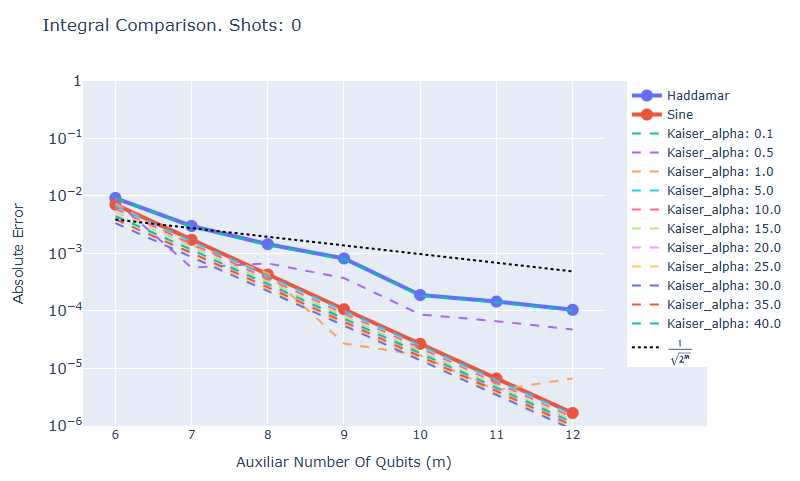

As can be seen for the same number of auxiliary qubits $m$ the absolute error (absolute difference between quantum estimation and Rieman sum over 6-qubits discretization) decreases when using a *Sine window function* or a properly configured *Kaiser window function* with respect to *Hadamard* (traditional **QPE**). 

For a large number of auxiliary qubits *Sine* and *Kaiser* could need even 2 qubits less than traditional **QPE** for the same absolute error.

The *Kaiser window function* theoretical performance is better than *sine* when it is properly configured (i.e. when a good $\alpha_{Kaiser}$ is provided).

### 8.2 Shots Simulation

The following graph shows the absolute error vs the number of auxiliary qubits when 10000 shots are simulated (in this case we present the median over 10 different repetitions).

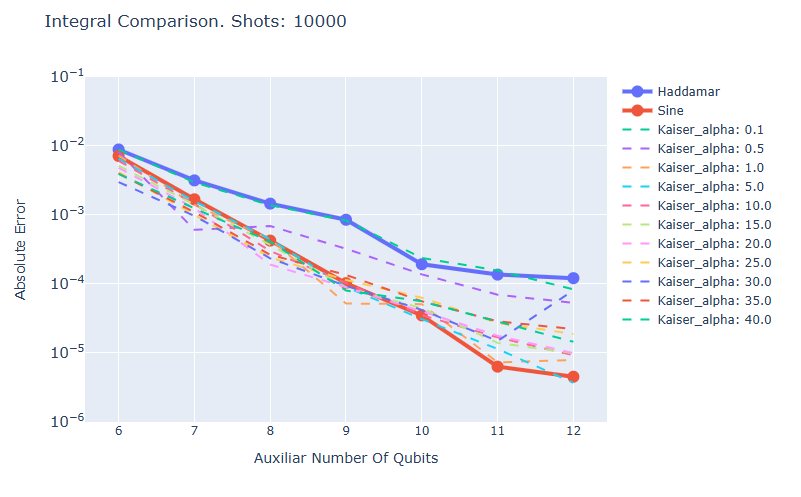

When shots are required the sine function shows a more stable perfomance than *Kaiser* windows (both of them have better perfromances than Hadamard). This performance decrease for *Kaiser windows* is due to the lower number of shots required. 

When shots are required the sine function shows a more stable perfomance than *Kaiser* windows (both of them have better perfromances than Hadamard). This performance decrease for *Kaiser windows* is due to the lower number of shots required. 

When the number of shots is increased the *Kaiser window* (properly configured) shows a slightly better performance than the *Sine window* as can be seen in the following graphs (where we presented the mean of the abolute error for 50 repetitions).

When the number of shots is increased the *Kaiser window* (properly configured) shows a slightly better performance than the *Sine window* as can be seen in the following graphs (where we presented the mean of the abolute error for 50 repetitions).

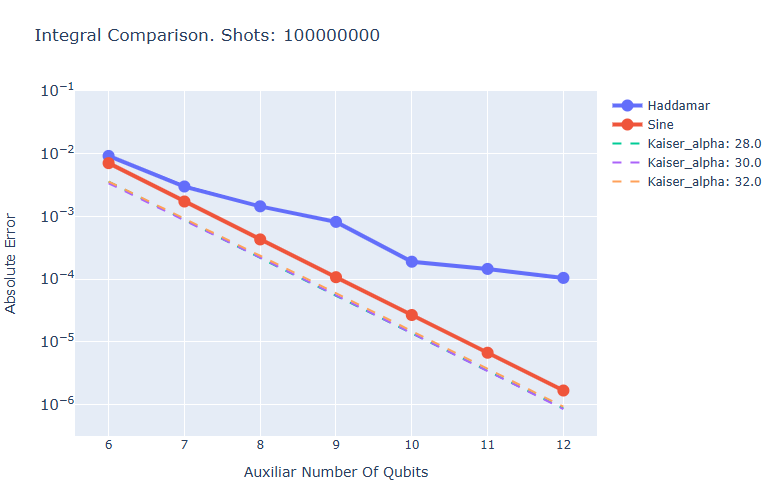